# Skin Disease Classification with Transfer Learning (MobileNetV2)
This notebook uses transfer learning for robust skin disease classification. It includes data exploration, augmentation, model training, evaluation, and saving.

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Input
from tensorflow.keras.models import Model

In [ ]:
# Set data directory and parameters
DATA_DIR = 'static/AugmentedSSkin'
IMG_SIZE = (128, 128)
BATCH_SIZE = 32

class_names = sorted(os.listdir(DATA_DIR))
num_classes = len(class_names)
print(f"Classes: {class_names}")

Classes: ['Atopic Dermatitis', 'Benign keratosis', 'Dermatofibroma', 'Melanocytic nevus', 'Melanoma', 'Psoriasis pictures Lichen Planus and related diseases', 'Squamous cell carcinoma', 'Tinea Ringworm Candidiasis', 'Vascular lesion']


C:\Users\hp\AppData\Local\Temp\ipykernel_6992\2639225728.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(class_image_counts.keys()), y=list(class_image_counts.values()), palette='viridis')


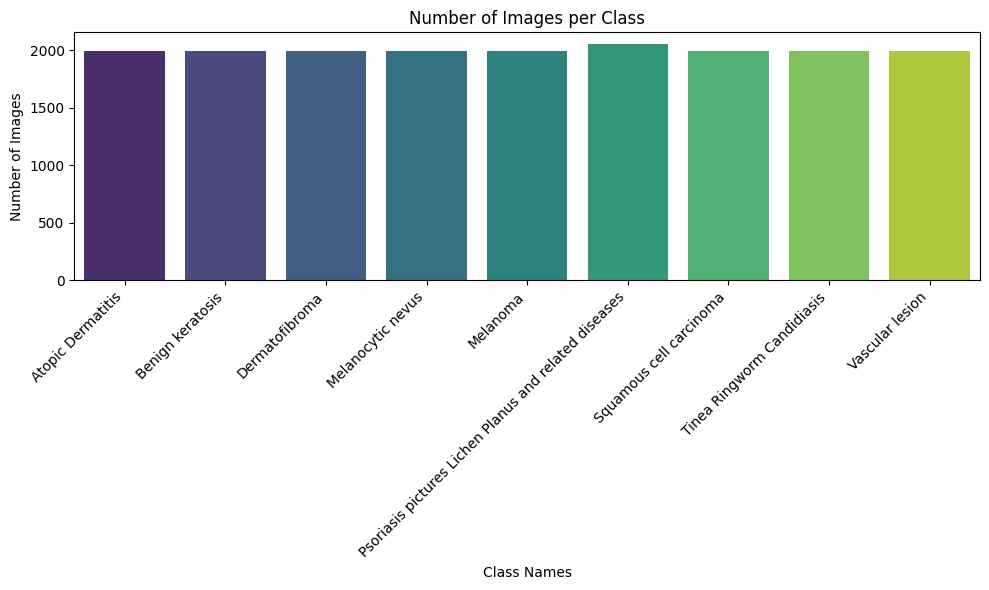

In [ ]:
# Data exploration: count images per class
class_image_counts = {}
for class_name in class_names:
    class_path = os.path.join(DATA_DIR, class_name)
    class_image_counts[class_name] = len(os.listdir(class_path))
plt.figure(figsize=(10, 6))
sns.barplot(x=list(class_image_counts.keys()), y=list(class_image_counts.values()), palette='viridis')
plt.xticks(rotation=45, ha='right')
plt.title("Number of Images per Class")
plt.xlabel('Class Names')
plt.ylabel('Number of Images')
plt.tight_layout()
plt.show()

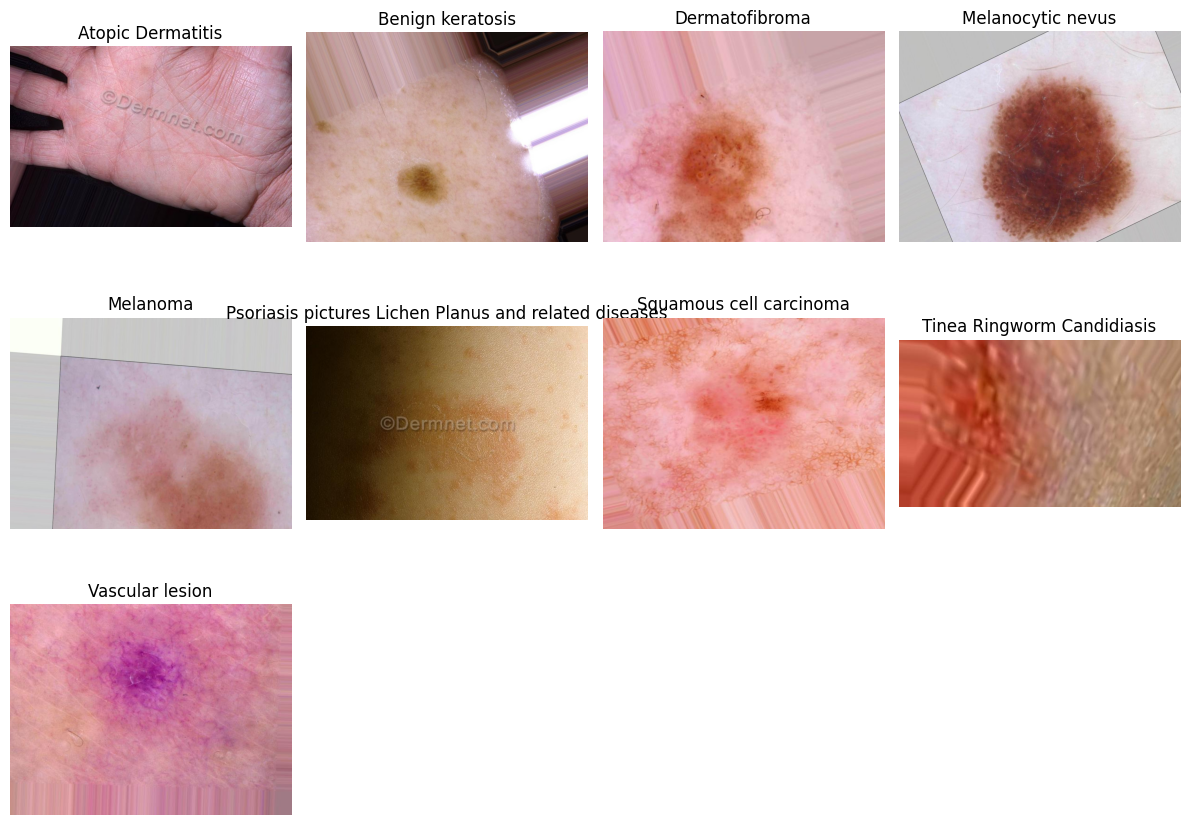

In [ ]:
# Visualize sample images
cols = 4
rows = (num_classes + cols - 1) // cols
plt.figure(figsize=(12, 3 * rows))
for i, class_name in enumerate(class_names):
    class_path = os.path.join(DATA_DIR, class_name)
    images = os.listdir(class_path)
    sample_image = random.choice(images)
    img = cv2.imread(os.path.join(class_path, sample_image))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(rows, cols, i + 1)
    plt.imshow(img)
    plt.title(class_name)
    plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

DATA_DIR = 'static/AugmentedSSkin'
IMG_SIZE = (64, 64)
BATCH_SIZE = 32

datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = datagen.flow_from_directory(
    DATA_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

validation_generator = datagen.flow_from_directory(
    DATA_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)


Found 14444 images belonging to 9 classes.
Found 3603 images belonging to 9 classes.


In [ ]:
def predict_image(file_path):
    try:
        image = Image.open(file_path).convert("RGB")
        img = image.resize((64, 64))  # ✅ Match model input shape
        img_array = img_to_array(img) / 255.0
        img_array = np.expand_dims(img_array, axis=0)

        if model:
            predictions = model.predict(img_array)
            prediction = CLASS_NAMES[np.argmax(predictions)]
            confidence = float(np.max(predictions)) * 100
            return prediction, confidence
        else:
            return None, "Model not loaded."
    except Exception as e:
        return None, f"Error processing image: {e}"


In [ ]:
# Load images and labels (RGB)
images = []
labels = []
valid_extensions = ('.jpg', '.jpeg', '.png')

for idx, class_name in enumerate(class_names):
    class_path = os.path.join(DATA_DIR, class_name)
    for img_name in os.listdir(class_path):
        if not img_name.lower().endswith(valid_extensions):
            continue  # Skip non-image files
        img_path = os.path.join(class_path, img_name)
        img = cv2.imread(img_path)
        if img is None:
            print(f"Warning: Failed to load image {img_path}")
            continue  # Skip if image is not loaded
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, IMG_SIZE)
        images.append(img)
        labels.append(idx)

images = np.array(images, dtype='float32') / 255.0
labels = np.array(labels)
print(f"Loaded {images.shape[0]} images.")


Loaded 18046 images.


In [ ]:
# Train/validation split
X_train, X_val, y_train, y_val = train_test_split(
    images, labels, test_size=0.2, stratify=labels, random_state=42
)
y_train_cat = to_categorical(y_train, num_classes)
y_val_cat = to_categorical(y_val, num_classes)

In [ ]:
# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
datagen.fit(X_train)

In [ ]:
# Build model with MobileNetV2 base
base_model = MobileNetV2(input_shape=IMG_SIZE + (3,), include_top=False, weights='imagenet')
base_model.trainable = False  # Freeze base

inputs = Input(shape=IMG_SIZE + (3,))
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
outputs = Dense(num_classes, activation='softmax')(x)
model = Model(inputs, outputs)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

C:\Users\hp\AppData\Local\Temp\ipykernel_6992\3079389721.py:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(input_shape=IMG_SIZE + (3,), include_top=False, weights='imagenet')


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 2, 2, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,423,113 (9.24 MB)

 Trainable params: 165,129 (645.04 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_skin_model.h5', monitor='val_loss', save_best_only=True)

# Train
history = model.fit(
    datagen.flow(X_train, y_train_cat, batch_size=BATCH_SIZE),
    epochs=30,
    validation_data=(X_val, y_val_cat),
    callbacks=[early_stop, checkpoint]
)

Epoch 1/30


C:\Users\hp\AppData\Roaming\Python\Python310\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


452/452 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.7445 - loss: 0.7805

452/452 ━━━━━━━━━━━━━━━━━━━━ 46s 92ms/step - accuracy: 0.7447 - loss: 0.7799 - val_accuracy: 0.9017 - val_loss: 0.3089
Epoch 2/30
452/452 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.8809 - loss: 0.3565

452/452 ━━━━━━━━━━━━━━━━━━━━ 40s 89ms/step - accuracy: 0.8809 - loss: 0.3564 - val_accuracy: 0.9100 - val_loss: 0.2756
Epoch 3/30
452/452 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.8976 - loss: 0.3013

452/452 ━━━━━━━━━━━━━━━━━━━━ 40s 88ms/step - accuracy: 0.8976 - loss: 0.3013 - val_accuracy: 0.9180 - val_loss: 0.2432
Epoch 4/30
452/452 ━━━━━━━━━━━━━━━━━━━━ 40s 88ms/step - accuracy: 0.9016 - loss: 0.2922 - val_accuracy: 0.9108 - val_loss: 0.2596
Epoch 5/30
452/452 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.9025 - loss: 0.2719

452/452 ━━━━━━━━━━━━━━━━━━━━ 41s 89ms/step - accuracy: 0.9025 - loss: 0.2719 - val_accuracy: 0.9266 - val_loss: 0.2242
Epoch 6/30
452/452 ━━━━━━━━━━━━━━━━━━━━ 45s 100ms/step - accuracy: 0.9035 - loss: 0.2660 - val_accuracy: 0.9180 - val_loss: 0.2374
Epoch 7/30
452/452 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.9119 - loss: 0.2526

452/452 ━━━━━━━━━━━━━━━━━━━━ 42s 94ms/step - accuracy: 0.9119 - loss: 0.2526 - val_accuracy: 0.9249 - val_loss: 0.2156
Epoch 8/30
452/452 ━━━━━━━━━━━━━━━━━━━━ 40s 88ms/step - accuracy: 0.9058 - loss: 0.2578 - val_accuracy: 0.9238 - val_loss: 0.2180
Epoch 9/30
452/452 ━━━━━━━━━━━━━━━━━━━━ 43s 96ms/step - accuracy: 0.9093 - loss: 0.2382 - val_accuracy: 0.9227 - val_loss: 0.2249
Epoch 10/30
452/452 ━━━━━━━━━━━━━━━━━━━━ 41s 92ms/step - accuracy: 0.9107 - loss: 0.2469 - val_accuracy: 0.9241 - val_loss: 0.2303
Epoch 11/30
452/452 ━━━━━━━━━━━━━━━━━━━━ 42s 92ms/step - accuracy: 0.9136 - loss: 0.2448 - val_accuracy: 0.9235 - val_loss: 0.2201
Epoch 12/30
452/452 ━━━━━━━━━━━━━━━━━━━━ 42s 92ms/step - accuracy: 0.9075 - loss: 0.2520 - val_accuracy: 0.9269 - val_loss: 0.2171


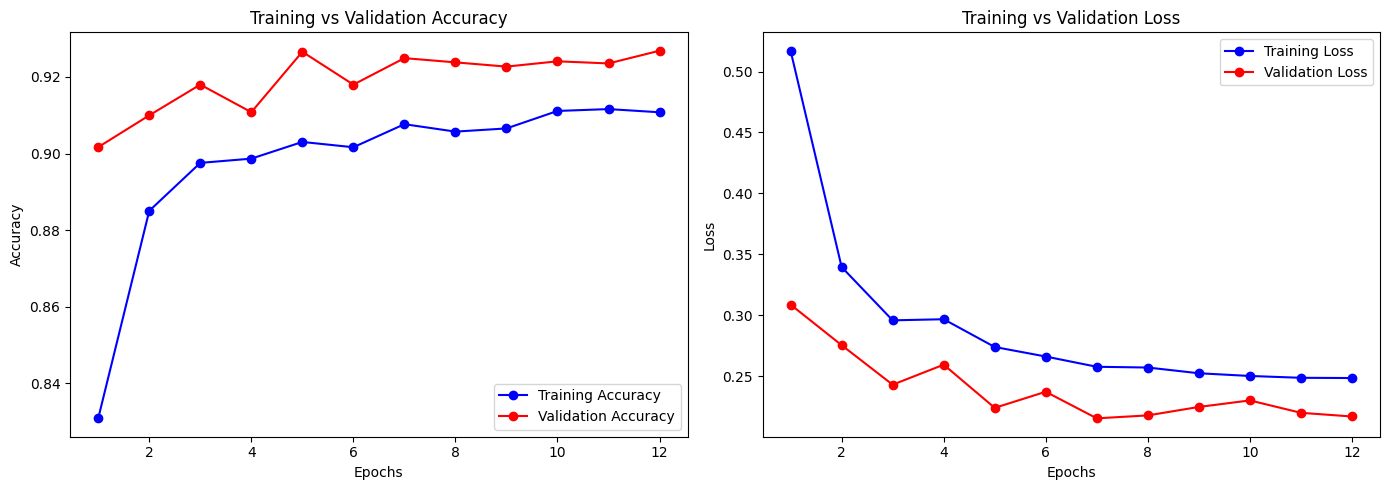

In [ ]:
# Plot training history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

113/113 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step


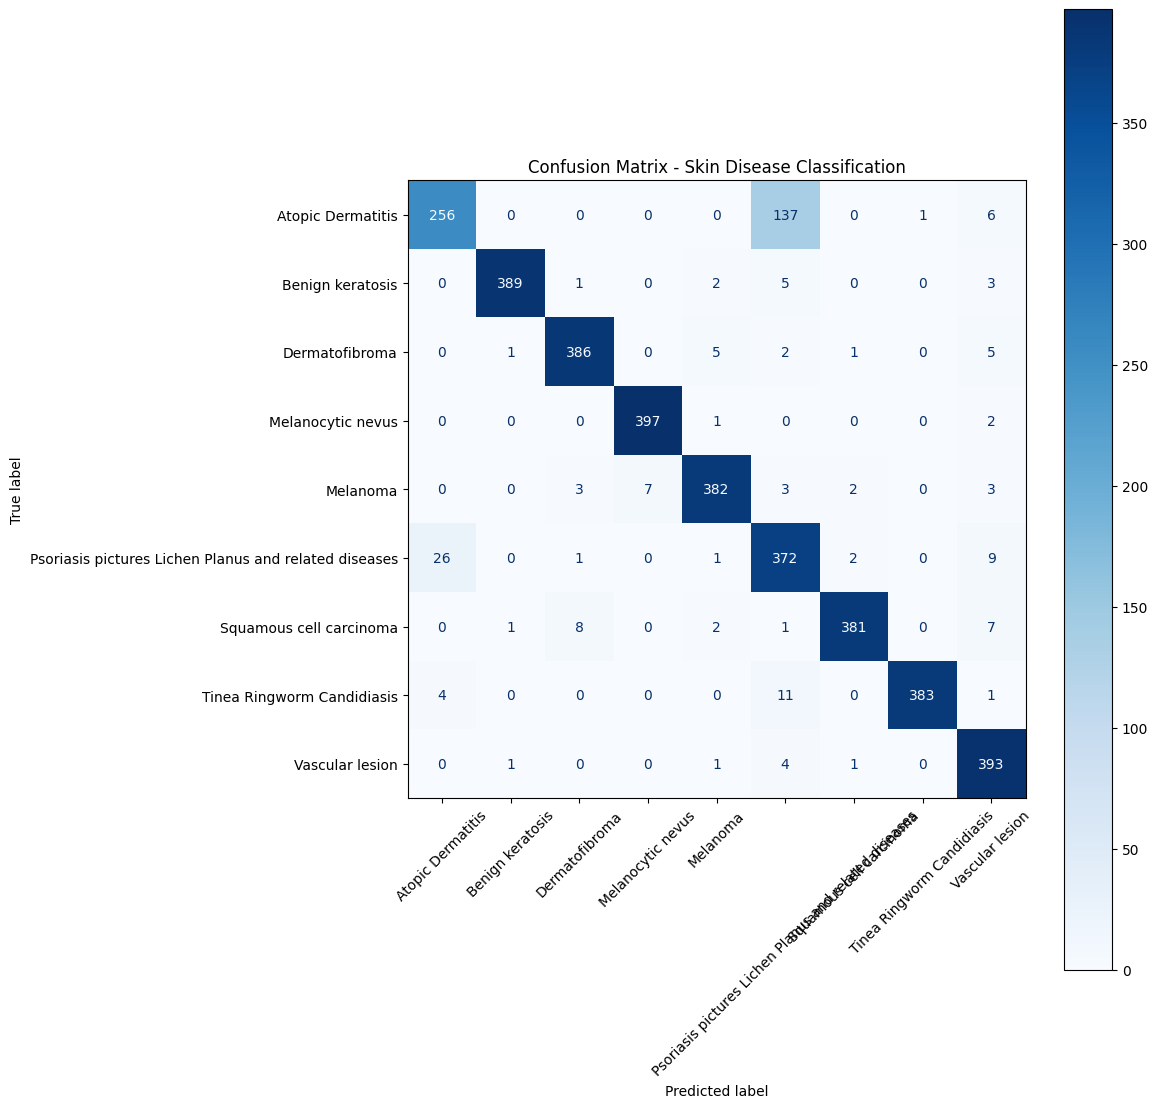

In [ ]:
# Confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred_probs = model.predict(X_val)
y_pred = np.argmax(y_pred_probs, axis=1)
cm = confusion_matrix(y_val, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(12, 12))
disp.plot(cmap='Blues', ax=ax, xticks_rotation=45, values_format='d')
plt.title("Confusion Matrix - Skin Disease Classification")
plt.tight_layout()
plt.show()

In [ ]:
# Save the best model
model.save('skin_disease_detector-lite1.h5')

**Tips:**
- You can unfreeze some layers of MobileNetV2 and fine-tune for even better results.
- Always validate with real-world images and consult medical experts for deployment.